In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from utils.data import read_dataset
from utils.image_preprocessing import preprocess_dataset
from utils.hyperparameter_optimizer import optimize_hyperparameters

from feature_extraction.extract_features import extract

%matplotlib inline

2024-02-10 13:56:49.156912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 13:56:49.156943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 13:56:49.157881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 13:56:49.162719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 13:56:49.974772: W tensorflow/compiler/tf2

# Loading data

In [2]:
X_raw_aug, y_aug = read_dataset('./data/rockpaperscissors/augmented_data')
X_raw_fin, y_fin = read_dataset('./data/rockpaperscissors/final_data')

permutation = np.random.permutation(len(y_aug) + len(y_fin))

X_raw, y = np.hstack([X_raw_aug, X_raw_fin])[permutation], np.hstack([y_aug, y_fin])[permutation]
X = preprocess_dataset(X_raw, image_shape=(300, 200))

/home/stas/uwr/sem5/ml/project/utils/data/data_reader.py:24: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(X, dtype=object)[permutation], np.array(y)[permutation]


In [3]:
X.shape

(14144, 60000)

In [4]:
y.shape

(14144,)

In [5]:
TRAIN_SIZE = int(0.8 * y.shape[0])
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]

In [6]:
X_train.shape

(11315, 60000)

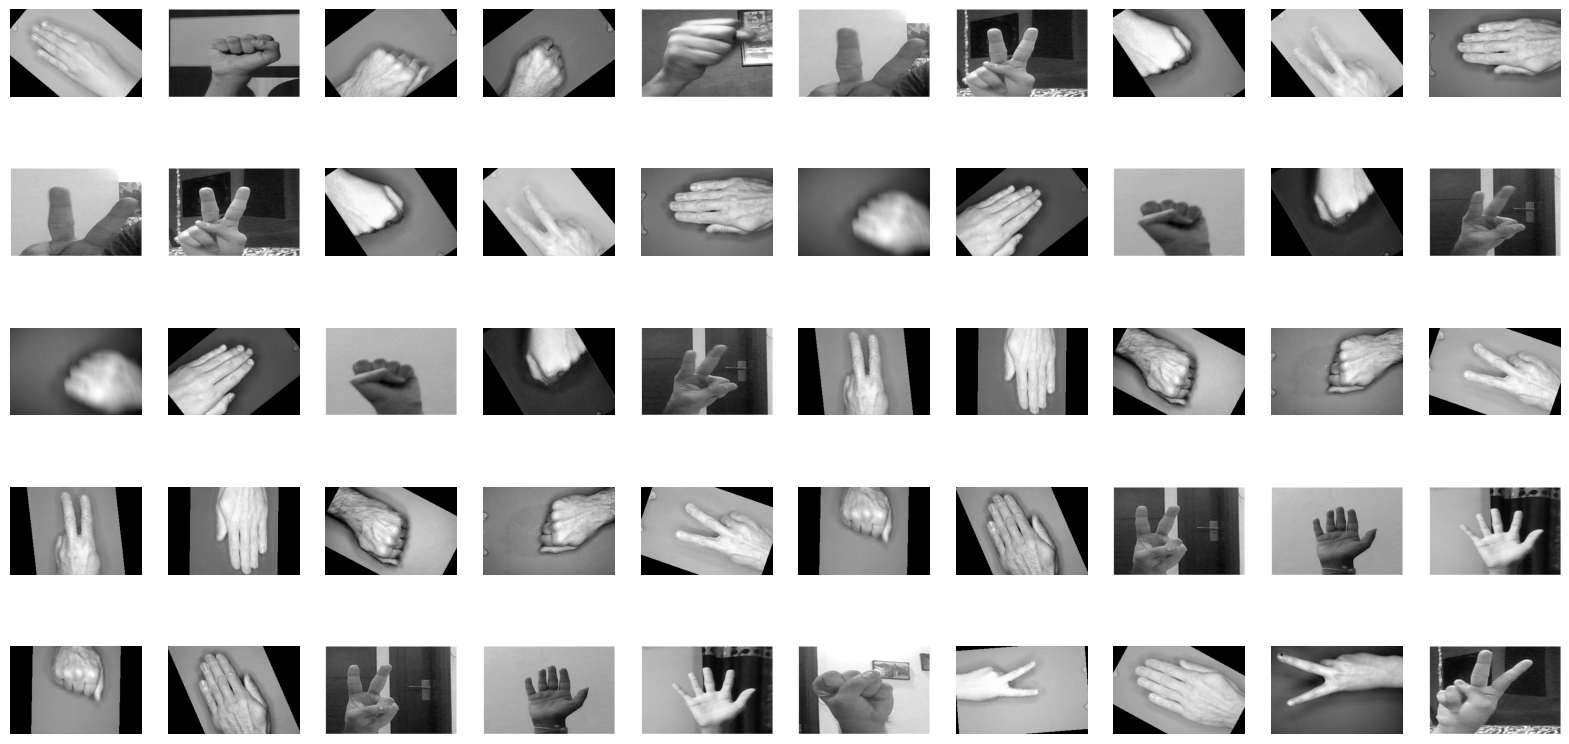

In [7]:
N,M = 5,10
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(X_train[N*i + j].reshape((200, 300)), cmap='gray')
        ax[i,j].axis('off')
plt.show()

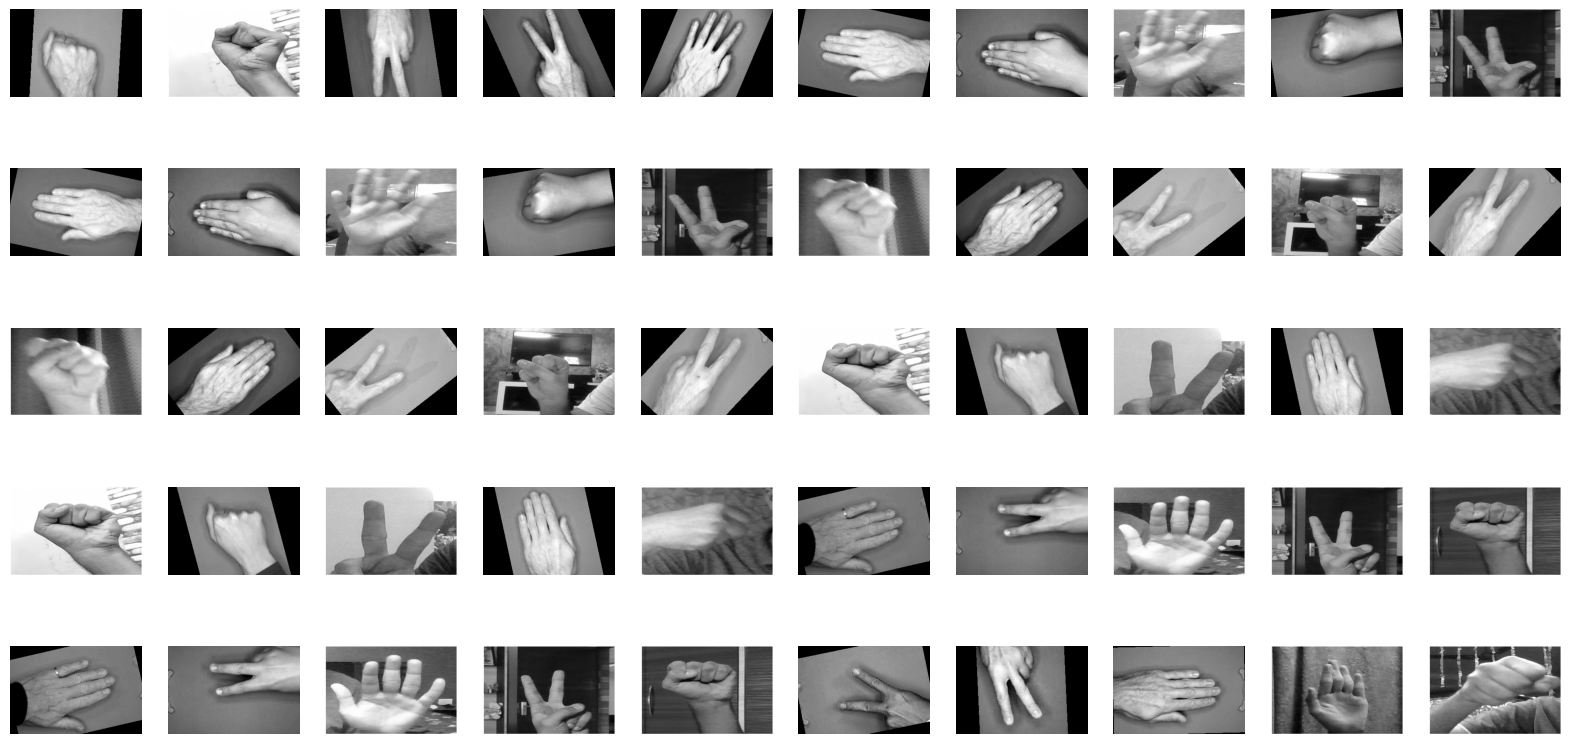

In [8]:
N,M = 5,10
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(X_test[N*i + j].reshape((200, 300)), cmap='gray')
        ax[i,j].axis('off')
plt.show()

In [9]:
pca_model = PCA(n_components=300)
X_pca = pca_model.fit_transform(X)

X_pca_train = X_pca[:TRAIN_SIZE]
X_pca_test = X_pca[TRAIN_SIZE:]

In [10]:
X_pca.shape

(14144, 300)

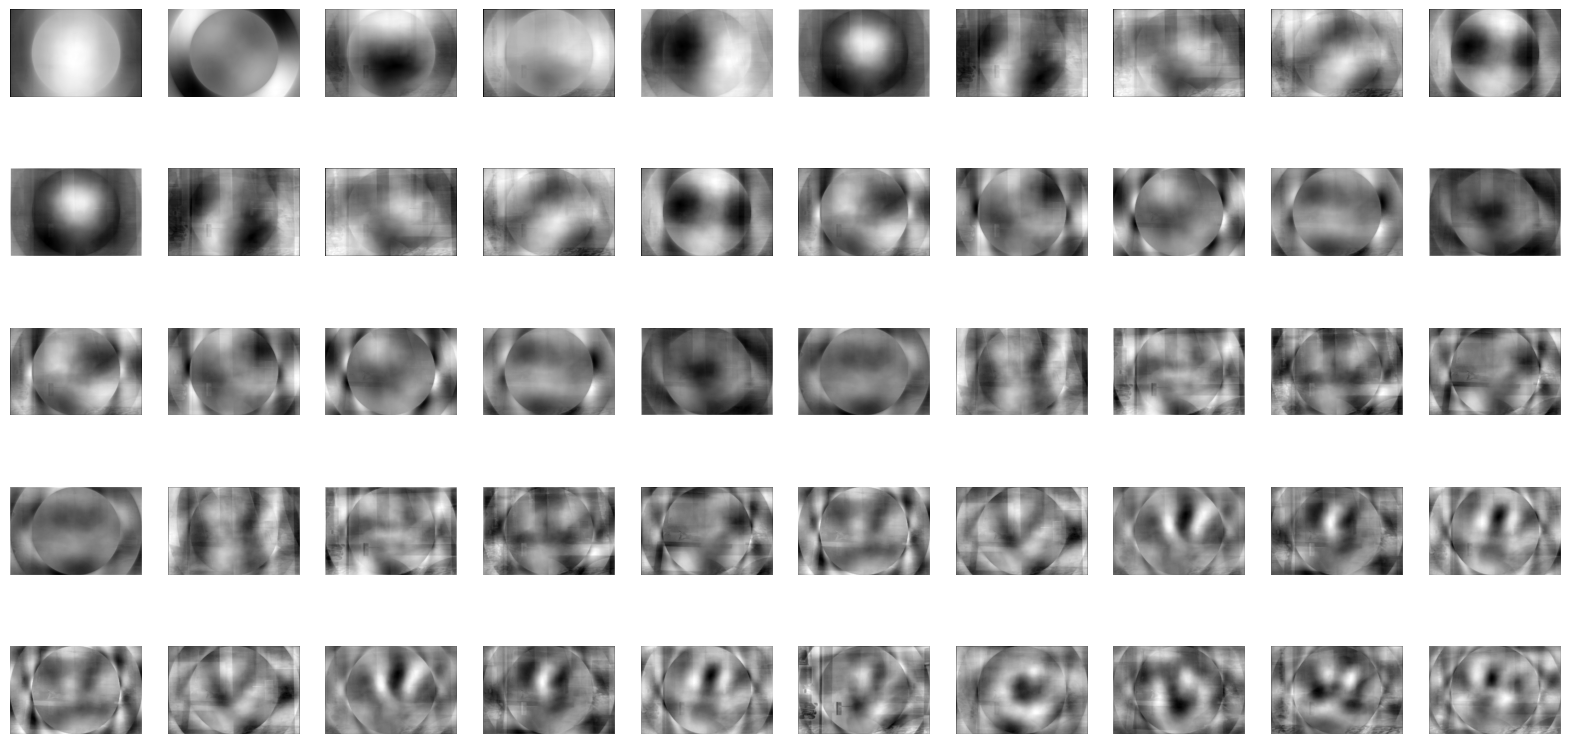

In [11]:
N,M = 5,10
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(pca_model.components_[N*i + j].reshape((200, 300)), cmap='gray')
        ax[i,j].axis('off')
plt.show()

### Feature extraction

In [10]:
X_extracted = extract(images=X_raw)
X_extracted_train = X_extracted[:TRAIN_SIZE]
X_extracted_test = X_extracted[TRAIN_SIZE:]

2024-02-10 13:11:22.003676: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-10 13:11:22.105132: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-10 13:11:22.105787: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-10 13:11:22.105810: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:110] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-02-10 13:11:22.106288: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-10 13:11:22.106321: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptx

In [11]:
X_extracted.shape

(14144, 4096)

In [12]:
model = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
model.fit(X_extracted_train, y_train)
model.score(X_extracted_test, y_test)

0.9487451396253093

# Training models

### KNN

In [13]:
best_knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
best_knn_model.fit(X_train, y_train)
best_knn_model.score(X_test, y_test)

0.8186638388123012

In [14]:
best_knn_model_pca = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
best_knn_model_pca.fit(X_pca_train, y_train)
best_knn_model_pca.score(X_pca_test, y_test)

0.8317426652527394

### XGBoost

In [25]:
best_xgboost_model = XGBClassifier(**{'max_depth': 8,
 'n_estimators': 279,
 'learning_rate': 0.17829011545082676,
 'subsample': 0.9124282632963587,
 'reg_alpha': 2.255571162185187,
 'reg_lambda': 4.323513303870824})
best_xgboost_model.fit(X_extracted_train, y_train)
best_xgboost_model.score(X_extracted_test, y_test)

0.9777306468716861

# Final test

In [12]:
X_raw_custom, y_custom = read_dataset('./data/rockpaperscissors/custom-test-data')
X_custom = preprocess_dataset(X_raw_custom, image_shape=(300, 200))

/home/stas/uwr/sem5/ml/project/utils/data/data_reader.py:24: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(X, dtype=object)[permutation], np.array(y)[permutation]


In [30]:
X_custom_extracted = extract(images=X_raw_custom)

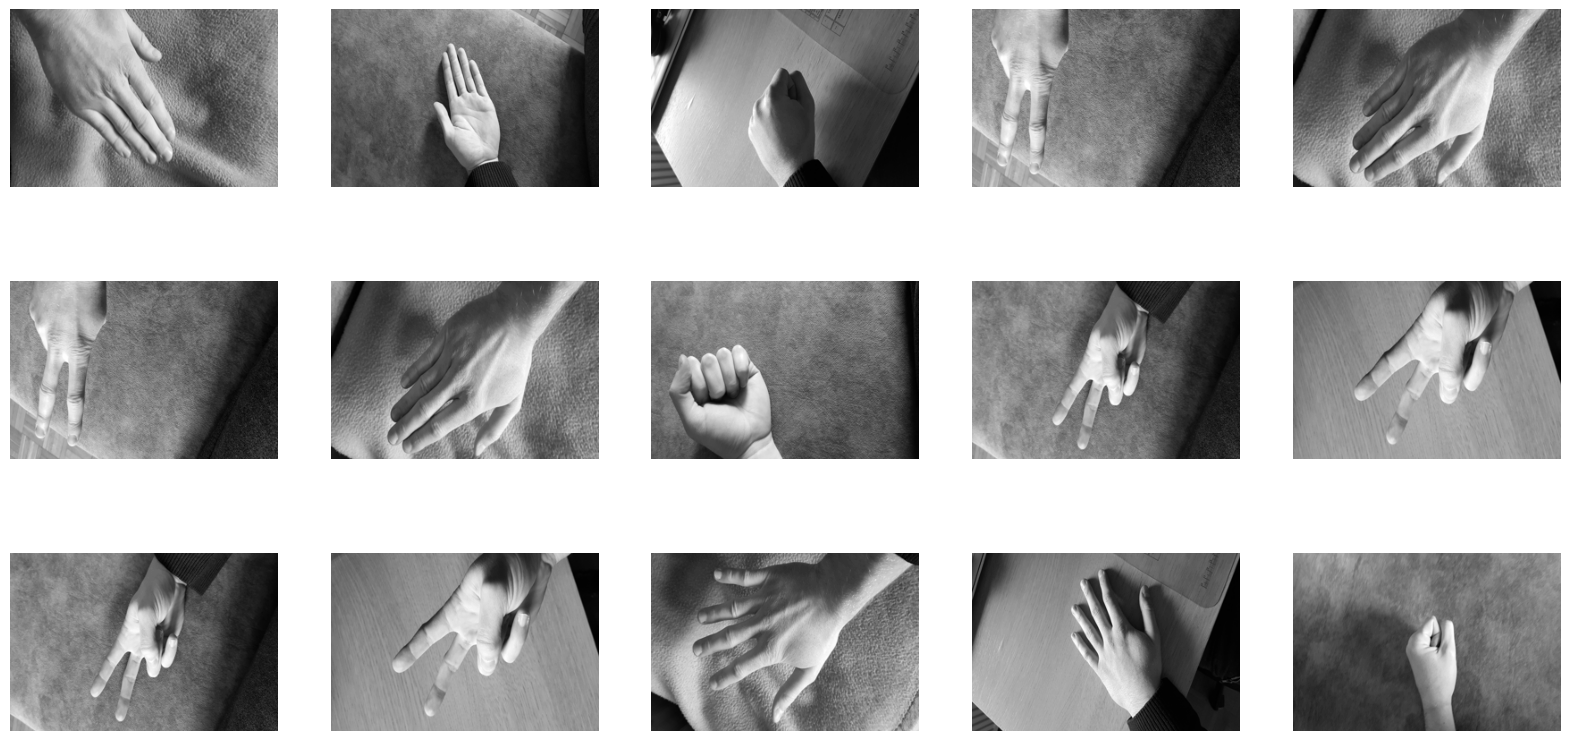

In [13]:
N,M = 3,5
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(X_custom[N*i + j].reshape((200, 300)), cmap='gray')
        ax[i,j].axis('off')
plt.show()

In [32]:
best_xgboost_model.score(X_custom_extracted, y_custom)

0.625

In [14]:
best_xgboost_model_pca = XGBClassifier(**{'max_depth': 8,
 'n_estimators': 279,
 'learning_rate': 0.17829011545082676,
 'subsample': 0.9124282632963587,
 'reg_alpha': 2.255571162185187,
 'reg_lambda': 4.323513303870824})
best_xgboost_model_pca.fit(X_pca_train, y_train)
best_xgboost_model_pca.score(pca_model.transform(X_custom), y_custom)

0.5